# Import Packages

In [1]:
import pandas as pd
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pyvis.network import Network
import distinctipy
from julia import Julia

# Load and Process Data to Build Graph

In [2]:
data = pd.read_csv('../Data/Courses.csv') # load all course data
courses = data["Course"].tolist() # all course names

graph = nx.DiGraph() # initialize an empty directed graph

topic_sizes = {} # dictionary of topic sizes
topic_courses = {} # dictionary of store topic-course mapping
review_sizes = {} # dictionary of review times between topics in specific courses
reviewed_topics = [] # list of topics that are reviewed
course_topics = {} # dictionary of all new topics introduced in a course
topic_course_sizes = {} # size of each topic in each course
simple_review_sizes = {} # dictionary of review sizes not indexed by course
weighted_review_sizes = {} # simple review size / number of topic sucessors in course it is reviewed in

for p,course in enumerate(courses):
    course_data = pd.read_csv(f'../Data/{course}.csv', encoding='unicode_escape') # get course data
    new_topics = []
    for index, row in course_data.iterrows(): # iterate over each row
        i = row['Topic']
        edges_to = row['Edges To']  
        size = row['Size']
        
        if i in topic_sizes:
            reviewed_topics.append(i)
        
        if not graph.has_node(i): # add node for topic if not already present
            graph.add_node(i, size=size)

        if pd.notnull(edges_to): # check if there are any edges to 
            edges_to = [topic.strip() for topic in edges_to.split(';')] # split edges_to
            num_rev = len(edges_to)

            for j in edges_to: # iterate over edges to 
                graph.add_edge(i, j) # add edge from i to j

                if i in topic_sizes: # add review time only if the topic has been taught in a previous course
                    review_sizes[i,j,p] = size
                    simple_review_sizes[i,j] = size
                    weighted_review_sizes[i,j] = size/num_rev

        if i not in topic_courses: # add info for a new topic 
            topic_courses[i] = [course]
            topic_sizes[i] = size
            new_topics.append(i)
            topic_course_sizes[i] = [size]
        else:
            topic_courses[i].append(course)
            topic_course_sizes[i].append(size)
            
    course_topics[course] = new_topics

reviewed_topics = list(set(reviewed_topics))

inter_data = pd.read_csv('../Data/Inter Connections.csv', encoding='unicode_escape') 

for index, row in inter_data.iterrows(): # add inter edges
    i = row['Topic']
    if i in topic_sizes.keys():
        edges_to = row['Edges To']
        if pd.notnull(edges_to): # check if there are any edges to
            edges_to = [topic.strip() for topic in edges_to.split(';')] # split edges_to 
            for j in edges_to: # iterate over edges_to
                if j in topic_sizes.keys():
                    graph.add_edge(i,j) # add edge from topic i to topic j
            
if not nx.is_directed_acyclic_graph(graph): # check if graph is directed and acyclic
    print("Not directed acyclic")

# Visualize Graph

In [3]:
def graph_base_nodes(pos,topic_module_sizes,filename): # create figure of graph colored by connection types
    figure = plt.figure(figsize=(15,15))
    
    node_size = [sum(topic_module_sizes[i]) for i in graph.nodes()]
    nx.draw(graph, pos, node_size=[2000*v for v in node_size], node_color='#000000', arrowsize=15, width=1.5, edge_color='#000000')
    
    sizes = {}
    node_color = {}
    label_pos = {}
    for i in graph.nodes:
        label_pos[i] = (pos[i][0], pos[i][1] - 33)
        sizes[i] = topic_module_sizes[i][0]
        successors = list(graph.successors(i))
        predecessors = list(graph.predecessors(i))
        connections = len(successors) + len(predecessors)
        node_color[i] = '#6F8FAF'
        if len(successors) == 0:
            node_color[i] = '#D2042D'
        if len(predecessors) == 0:
            node_color[i] = '#008000'
        if connections == 0:
            node_color[i] = '#000000'
    
    nx.draw_networkx_nodes(graph, pos, node_size=[2000*v for v in sizes.values()],node_color=[v for v in node_color.values()])
    labels = nx.draw_networkx_labels(graph, label_pos, font_size=16, font_family='serif')

    figure.savefig(filename,format="pdf")
    
    return figure

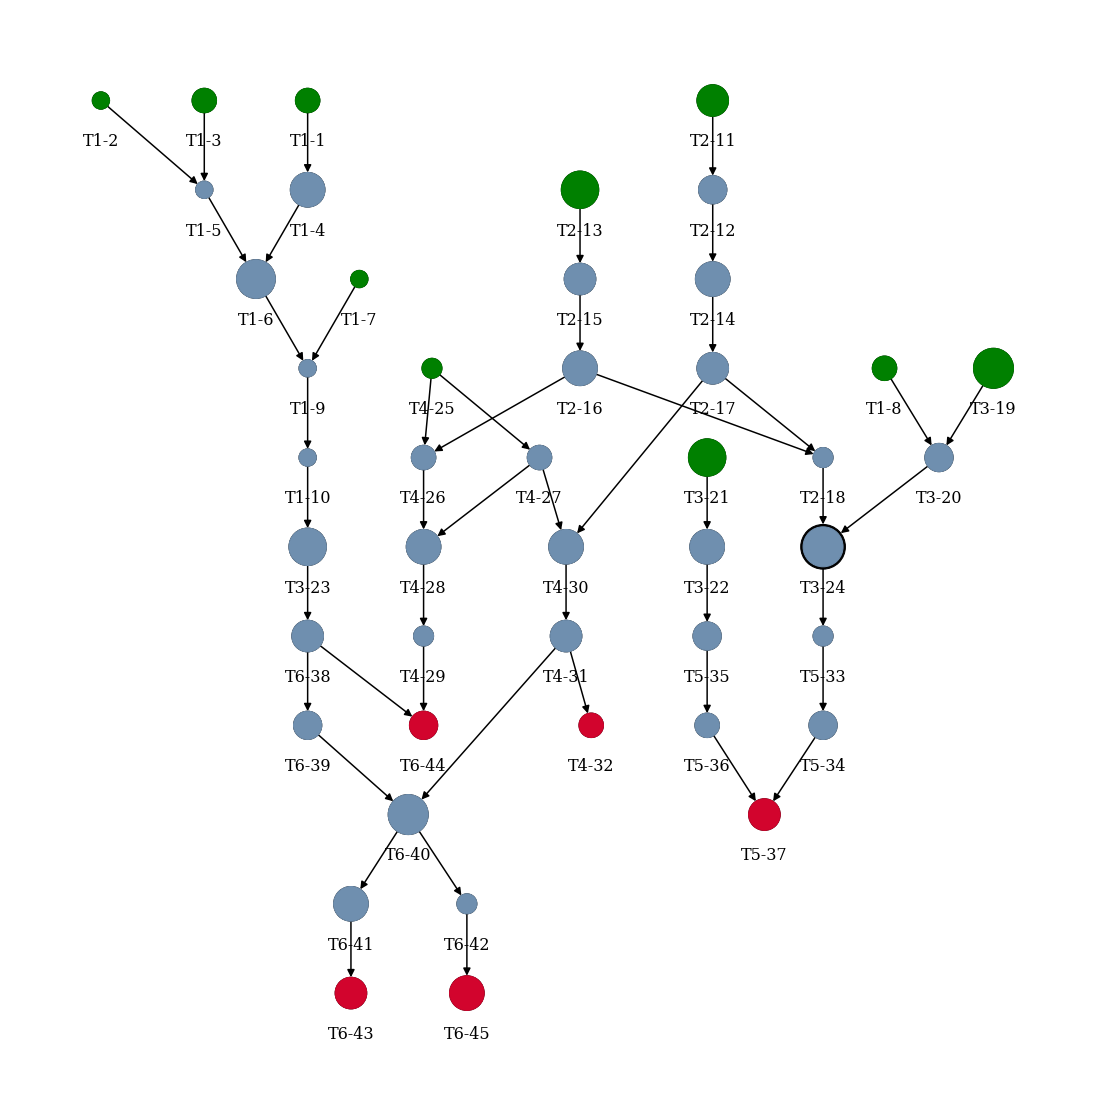

In [4]:
pos_base = nx.nx_agraph.graphviz_layout(graph,prog='dot', args='-Grankdir=TB -Granksep=equally -Gnodesep=equally -Grank=max')

base_figure = graph_base_nodes(pos_base,topic_course_sizes,"../Curriculum Graphs/Curriculum A Topics.pdf")

# Topic Grouping

## Modularity (no sequence)

In [5]:
jl = Julia(runtime='C:/Users/blake/AppData/Local/Programs/Julia 1.5.3/bin/julia.exe') # path to julia 

module_code = """
using JuMP, Gurobi, LinearAlgebra

function make_modules(A,n_m,topic_sizes,max_size,min_size,review,review_sizes,time_limit)
    # A = topic dependency matrix
    # n_m = number of modules
    # topic_sizes = sizes of topics
    # max_size = maximum size of module
    # min_size = minimum size of module
    # review = binary review matrix if topic i is reviewed to teach topic j
    # review_sizes = size of reviewing topic i to teach topic j
    
    n_t = length(A[1,:])
    m = sum(A)

    mm=Model(optimizer_with_attributes(Gurobi.Optimizer,"TimeLimit"=>time_limit))

    @variable(mm, x[1:n_t,1:n_m], Bin) # module population matrix

    @constraint(mm, [i in 1:n_t], sum(x[i,p] for p in 1:n_m)==1) # each topic is assigned to one modules
    @constraint(mm, [p in 1:n_m], sum(x[i,p] for i in 1:n_t)>=1) # ecach module has at least one topic
    
    @variable(mm, module_size[1:n_m]) # size of each module
    @variable(mm, r[1:n_t,1:n_t,1:n_m], Bin) # if a topic i is reviewed in module p to teach topic j
    
    @constraint(mm, [i in 1:n_t,j in 1:n_t,p in 1:n_m], r[i,j,p] == x[i,p] * (1 - x[j,p]) * review[j,i])
    @constraint(mm, [p in 1:n_m], module_size[p] == sum(x[i,p] * topic_sizes[i] for i in 1:n_t) + sum(review_sizes[i,j] * r[i,j,p] for j in 1:n_t for i in 1:n_t if i != j)) # calculate the size of each module
    @constraint(mm, [p in 1:n_m], min_size <= module_size[p] <= max_size) # each module is size restricted

    @objective(mm, Max, 1/2/m*sum(A[i,j]*x[i,t]*x[j,t] for i in 1:n_t for j in 1:n_t for t in 1:n_m)) # maximize modularity 
    
    optimize!(mm)

    X = value.(x)
    X_bool = X .> 0
    groups = [findall(X_bool[:,p]) for p in 1:n_m]
    modules = convert(Array{Any}, [convert(Array{Any},group) for group in groups])

    R = value.(r)
    R_bool = R .> 0.1
    
    reviews = []
    for p in 1:n_m
        for i in 1:n_t
            for j in 1:n_t
                if R_bool[i, j, p]
                    push!(reviews, (i,j,p))
                end
            end
        end
    end

    modularity = JuMP.objective_value(mm)

    return (modules, modularity, reviews)

end
"""
jl.eval(module_code)

def make_modules(n_m, max_size, min_size, time_limit): # make n_m modules of a specific size 
    A = nx.to_numpy_array(graph)
    nodes = list(graph.nodes(data=False))
    n_t = len(nodes)
    sizes = [topic_sizes[i] for i in nodes]
    node_dict = dict(zip(range(1,n_t+1),nodes)) # dictionary used for communication between python and julia

    # rewrite data for julia format
    review = np.zeros([n_t,n_t])
    review_size = np.zeros([n_t,n_t])
    for ii,i in enumerate(nodes):
        for jj, j in enumerate(nodes):
            if (i,j) in weighted_review_sizes.keys():
                review[jj,ii] = 1
                review_size[ii,jj] = weighted_review_sizes[i,j] 

    julia_A = "[" + "; ".join("[" + " ".join(map(str, row)) + "]" for row in A) + "]"
    julia_review = "[" + "; ".join("[" + " ".join(map(str, row)) + "]" for row in review) + "]"
    julia_review_size = "[" + "; ".join("[" + " ".join(map(str, row)) + "]" for row in review_size) + "]"

    (modules,modularity,reviews) = jl.eval(f"make_modules({julia_A},{n_m},{sizes},{max_size},{min_size},{julia_review},{julia_review_size},{time_limit})") # send to julia
    
    # rewrite results for python format
    review_list = []
    for review in reviews:
        review_list.append([node_dict[review[0]],node_dict[review[1]]])
                    
    for i in range(len(modules)):
            for j in range(len(modules[i])):
                    modules[i][j] = node_dict[modules[i][j]]
                    
    return (modules,modularity,review_list)

C:\Users\blake\Anaconda3\lib\site-packages\julia\core.py:709: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  warnings.warn(


In [6]:
n_m = 6
max_size = 4.1
min_size = 2.9
time_limit = 60*10
(modules,modularity,module_reviews) = make_modules(n_m, max_size, min_size,time_limit)

In [7]:
def process_modules(modules,reviews): # unpack results of new modules
    topic_modules = {}
    topic_module_sizes = {}
    for p, topics in enumerate(modules):
        for i in topics:
            topic_modules[i] = [p]
            topic_module_sizes[i] = [topic_sizes[i]]

    # see which topics are reviewed in the new modules
    module_review_sizes = {}
    module_reviewed_topics = []
    for review in reviews:
        i = review[0]
        j = review[1]
        p = topic_modules[j][0]
        module_review_sizes[i,j,p] = simple_review_sizes[i,j]
        if i not in module_reviewed_topics:
            module_reviewed_topics.append(i)
        if p not in topic_modules[i]:
            topic_modules[i].append(p)
            topic_module_sizes[i].append(simple_review_sizes[i,j])
    
    # determine module sizes
    module_size = []
    for p,topics in enumerate(modules):
        size = 0
        topics_checked = []
        for i in topics:
            size += topic_sizes[i]
            for j in graph.nodes():
                if (j,i,p) in module_review_sizes.keys() and j not in topics_checked and j not in topics:
                    size += module_review_sizes[j,i,p]
                    topics_checked.append(j)

        module_size.append(size)
                            
    return (topic_modules, topic_module_sizes, module_size, module_review_sizes, module_reviewed_topics)

def graph_module_nodes(pos,module_colors,topic_modules,topic_module_sizes,filename): # create a graph of modules with coloring for reviews
    figure = plt.figure(figsize=(15,15))
    
    edge_color = [module_colors[topic_modules[edge[1]][0]] for edge in list(graph.edges())]
    node_size_module = [sum(topic_module_sizes[i]) for i in graph.nodes()]
    nx.draw(graph, pos, node_size=[2000*v for v in node_size_module], node_color='#FFFFFF',
            arrowsize=15, width=1.5, edge_color=edge_color)
    
    label_pos = {}
    for node in graph.nodes:
        label_pos[node] = (pos_base[node][0], pos_base[node][1] - 33)
        
    labels = nx.draw_networkx_labels(graph, label_pos, font_size=16, font_family='serif')
    
    layers = max([len(value) for value in topic_modules.values()])
    
    for q in range(layers-1,-1,-1):
        sizes = {}
        colors = {}
        for i in graph.nodes():
            if len(topic_modules[i]) - 1 >= q:
                colors[i] = module_colors[topic_modules[i][q]]
                size = sum(topic_module_sizes[i][0:q+1])
            else: 
                size = topic_sizes[i]
                colors[i] =  module_colors[topic_modules[i][0]]
            
            sizes[i] = size
        nx.draw_networkx_nodes(graph, pos, node_size=[2000*v for v in sizes.values()],node_color=[v for v in colors.values()])
    figure.savefig(filename,format="PDF")
    
    return figure

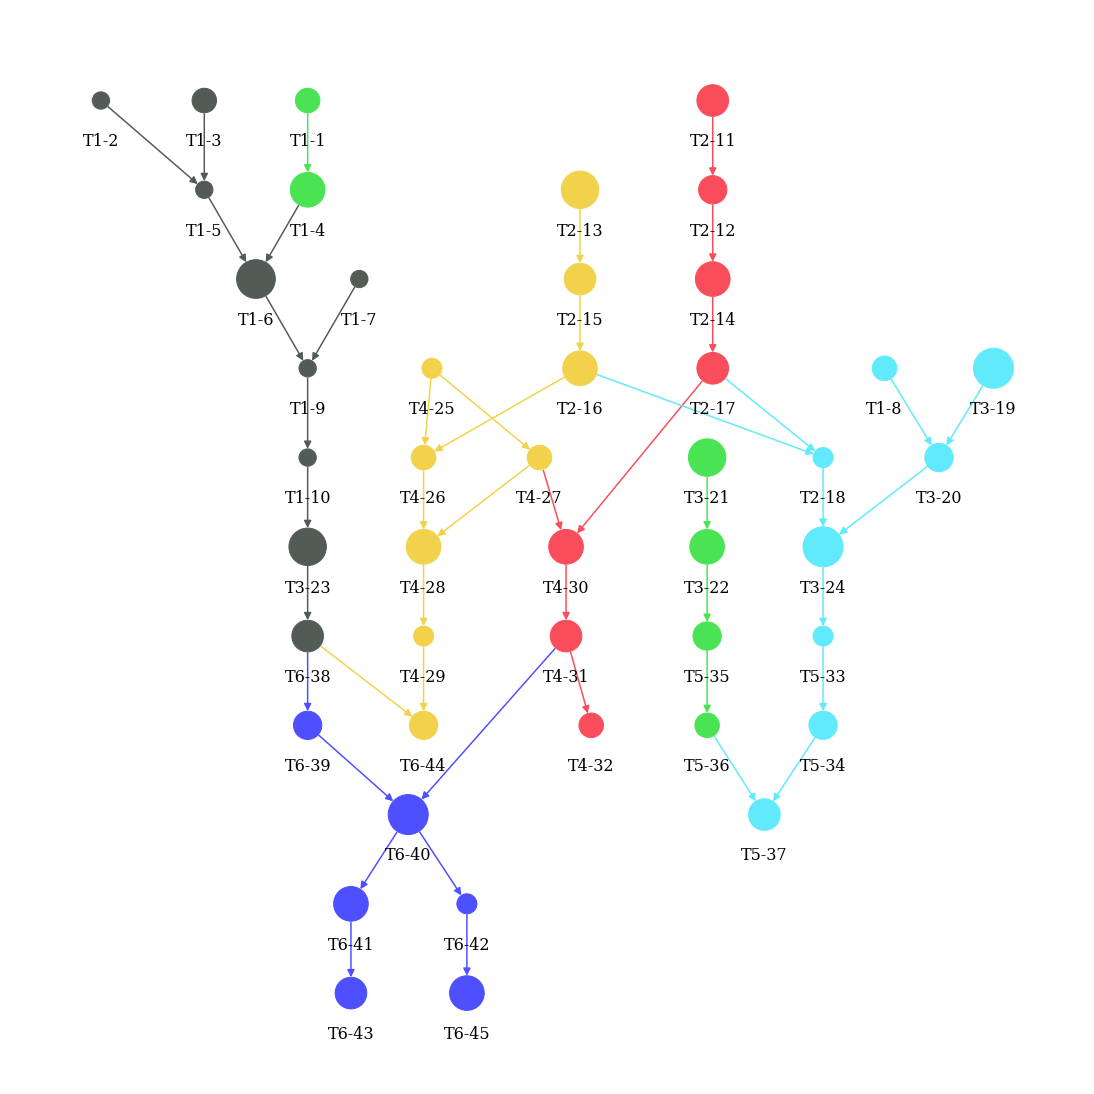

In [8]:
(topic_modules, topic_module_sizes, module_size, module_review_sizes, module_reviewed_topics) = process_modules(modules,module_reviews)

colors = ['#4e4fff', '#4ae354', '#f94d5b', '#60eafb', '#f2d24b', '#535b57']
module_colors = dict(zip(np.arange(0,n_m,1),colors))

module_figure = graph_module_nodes(pos_base,module_colors,topic_modules,topic_module_sizes,"../Curriculum Graphs/Curriculum A-Modules.pdf")

## Sequenced Modularity 

In [9]:
sequenced_module_code = """
using JuMP, Gurobi, LinearAlgebra

function make_sequenced_modules(A,n_m,topic_sizes,max_size,min_size,review,review_sizes,time_limit)
    # A = topic dependency matrix
    # n_m = number of modules
    # topic_sizes = sizes of topics
    # max_size = maximum size of module
    # min_size = minimum size of module
    # review = binary review matrix if topic i is reviewed to teach topic j
    # review_sizes = size of reviewing topic i  to teach topic j

    n_t = length(A[1,:]) # number of topics
    m = sum(A)
    
    if (n_t - n_m) % 2 == 0
        M = ((n_t - n_m + 2) / 2)^2
    else
        M = ((n_t - n_m + 1) / 2)^2 + ((n_t - n_m + 1) / 2)
    end

    mm=Model(optimizer_with_attributes(Gurobi.Optimizer,"TimeLimit"=>time_limit))

    @variable(mm, x[1:n_t,1:n_m], Bin) # module population matrix

    @constraint(mm, [i in 1:n_t], sum(x[i,p] for p in 1:n_m)==1) # each topic is assigned to one modules
    @constraint(mm, [p in 1:n_m], sum(x[i,p] for i in 1:n_t)>=1) # ecach module has at least one topic
    
    @variable(mm, module_size[1:n_m]) # size of each module
    @variable(mm, r[1:n_t,1:n_t,1:n_m], Bin) # if a topic i is reviewed in module p to teach topic j
    
    @constraint(mm, [i in 1:n_t,j in 1:n_t,p in 1:n_m], r[i,j,p] == x[i,p] * (1 - x[j,p]) * review[j,i])
    @constraint(mm, [p in 1:n_m], module_size[p] == sum(x[i,p] * topic_sizes[i] for i in 1:n_t) + sum(review_sizes[i,j] * r[i,j,p] for j in 1:n_t for i in 1:n_t if i != j)) # calculate the size of each module
    @constraint(mm, [p in 1:n_m], min_size <= module_size[p] <= max_size) # each module is size restricted

    @objective(mm, Max, 1/2/m*sum(A[i,j]*x[i,t]*x[j,t] for i in 1:n_t for j in 1:n_t for t in 1:n_m)) # maximize modularity 

    @variable(mm, B[1:n_m,1:n_m]) # matrix of number of edges between modules

    @constraint(mm, B .== transpose(x)*A*x)

    @variable(mm, C[1:n_m,1:n_m], Bin) # matrix representing directed edges between modules

    for p in 1:n_m
        for q in 1:n_m
            if p != q
                @constraint(mm, C[p,q] >= B[p,q] / M)
                @constraint(mm, C[p,q] <= B[p,q])
            else
                @constraint(mm, C[p,q] == 0)
            end
        end
    end

    @variable(mm, D[1:n_m,1:n_m,1:n_m]) # matrix showing the modules accessed depending on the number of steps

    for L in 1:n_m
        for p in 1:n_m
            for q in 1:n_m
                if L == 1
                    @constraint(mm, D[p, q, L] == C[p, q])
                else
                    @constraint(mm, D[p, q, L] == sum(D[p, k, L-1] * C[k, q] for k in 1:n_m))
                end
            end
        end
    end

    @variable(mm, E[1:n_m,1:n_m]) # matrix showing paths from module to module

    @constraint(mm, E .== sum(D[:,:,i] for i in 1:n_m)) 

    @variable(mm, F[1:n_m,1:n_m], Bin) # matrix representing if there is a path from one node to another

    for p in 1:n_m
        for q in 1:n_m
            @constraint(mm, F[p,q] >= E[p,q] / 2^(n_m-2))
            @constraint(mm, F[p,q] <= E[p,q])
        end
    end

    for p in 1:n_m
        for q in 1:n_m
            @constraint(mm, F[p,q] + F[q,p] <= 1)
        end
    end

    optimize!(mm)

    X = value.(x)
    X_bool = X .> 0
    groups = [findall(X_bool[:,p]) for p in 1:n_m]
    modules = convert(Array{Any}, [convert(Array{Any},group) for group in groups])

    R = value.(r)
    R_bool = R .> 0.1
    
    reviews = []
    for p in 1:n_m
        for i in 1:n_t
            for j in 1:n_t
                if R_bool[i, j, p]
                    push!(reviews, (i,j,p))
                end
            end
        end
    end

    modularity = JuMP.objective_value(mm)

    return (modules, modularity, reviews)
    
end
"""
jl.eval(sequenced_module_code)

def make_sequenced_modules(n_m, max_size, min_size, time_limit): # make sequenced modules of a specific size
    A = nx.to_numpy_array(graph)
    nodes = list(graph.nodes(data=False))
    n_t = len(nodes)
    sizes = [topic_sizes[i] for i in nodes]
    node_dict = dict(zip(range(1,n_t+1),nodes)) # dictionary used for communication between python and julia
    
    # rewrite data for julia format
    review = np.zeros([n_t,n_t])
    review_size = np.zeros([n_t,n_t])
    for ii,i in enumerate(nodes):
        for jj, j in enumerate(nodes):
            if (i,j) in weighted_review_sizes.keys():
                review[jj,ii] = 1
                review_size[ii,jj] = weighted_review_sizes[i,j] 

    julia_A = "[" + "; ".join("[" + " ".join(map(str, row)) + "]" for row in A) + "]"
    julia_review = "[" + "; ".join("[" + " ".join(map(str, row)) + "]" for row in review) + "]"
    julia_review_size = "[" + "; ".join("[" + " ".join(map(str, row)) + "]" for row in review_size) + "]"

    (modules,modularity,reviews) = jl.eval(f"make_sequenced_modules({julia_A},{n_m},{sizes},{max_size},{min_size},{julia_review},{julia_review_size},{time_limit})") # send to julia
    
    # rewrite results for python format
    review_list = []
    for review in reviews:
        review_list.append([node_dict[review[0]],node_dict[review[1]]])
                    
    for i in range(len(modules)):
            for j in range(len(modules[i])):
                    modules[i][j] = node_dict[modules[i][j]]
                    
    return (modules,modularity,review_list)

C:\Users\blake\Anaconda3\lib\site-packages\julia\core.py:709: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  warnings.warn(


In [10]:
n_m = 6
max_size = 4.1
min_size = 2.9
time_limit = 60*10
(sequenced_modules,sequenced_modularity,sequenced_module_reviews) = make_sequenced_modules(n_m, max_size, min_size, time_limit)

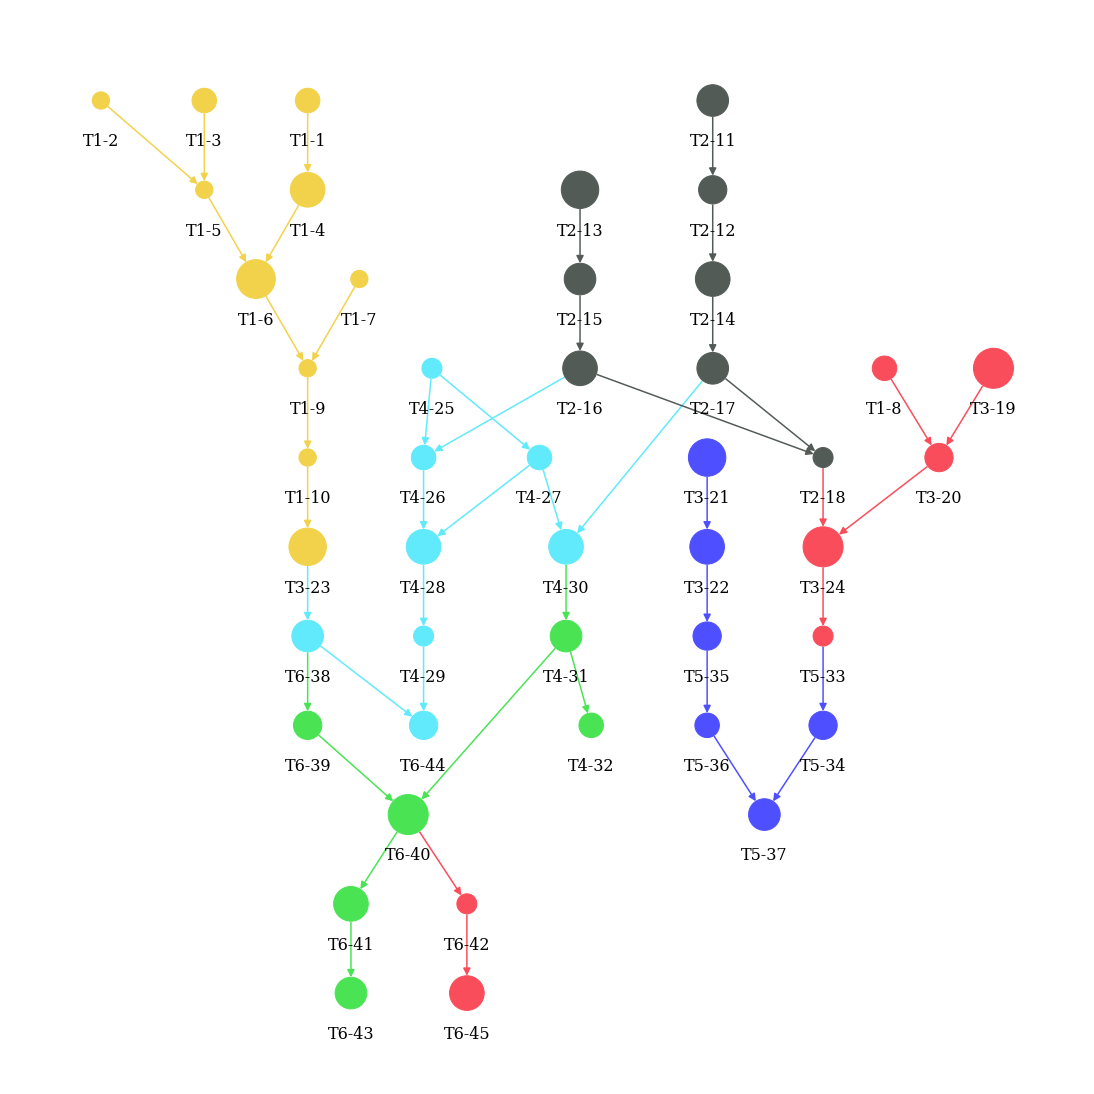

In [11]:
(topic_sequenced_modules, topic_sequenced_module_sizes, sequenced_module_size, sequenced_module_review_sizes, sequenced_module_reviewed_topics) = process_modules(sequenced_modules,sequenced_module_reviews)

colors = ['#4e4fff', '#4ae354', '#f94d5b', '#60eafb', '#f2d24b', '#535b57']
sequenced_module_colors = dict(zip(np.arange(0,n_m,1),colors))

sequenced_module_figure = graph_module_nodes(pos_base,sequenced_module_colors,topic_sequenced_modules,topic_sequenced_module_sizes,"../Curriculum Graphs/Curriculum A-Sequenced Modules.pdf")

# LPA Sequenced Modules

In [12]:
LPA_sequenced_module_code = """
using JuMP, Gurobi, LinearAlgebra

function make_LPA_sequenced_modules(A,n_m,topic_sizes,max_size,min_size,review,review_sizes,time_limit)
    # A = topic dependency matrix
    # n_m = number of modules
    # topic_sizes = sizes of topics
    # max_size = maximum size of module
    # min_size = minimum size of module
    # review = binary review matrix if topic i is reviewed to teach topic j
    # review_sizes = size of reviewing topic i to teach topic j

    n_t = length(A[1,:])
    m = sum(A)

    mm=Model(optimizer_with_attributes(Gurobi.Optimizer,"TimeLimit"=>time_limit))

    @variable(mm, x[1:n_t,1:n_m], Bin) # module population matrix

    @constraint(mm, [i in 1:n_t], sum(x[i,p] for p in 1:n_m)==1) # each topic is assigned to one modules
    @constraint(mm, [p in 1:n_m], sum(x[i,p] for i in 1:n_t)>=1) # ecach module has at least one topic
    
    @variable(mm, module_size[1:n_m]) # size of each module
    @variable(mm, r[1:n_t,1:n_t,1:n_m], Bin) # if a topic i is reviewed in module p to teach topic j
    
    @constraint(mm, [i in 1:n_t,j in 1:n_t,p in 1:n_m], r[i,j,p] == x[i,p] * (1 - x[j,p]) * review[i,j])
    @constraint(mm, [p in 1:n_m], module_size[p] == sum(x[i,p] * topic_sizes[i] for i in 1:n_t) + sum(review_sizes[i,j] * r[i,j,p] for j in 1:n_t for i in 1:n_t if i != j)) # calculate the size of each module
    @constraint(mm, [p in 1:n_m], min_size <= module_size[p] <= max_size) # each module is size restricted

    @objective(mm, Max, 1/2/m*sum(A[i,j]*x[i,p]*x[j,p] for i in 1:n_t for j in 1:n_t for p in 1:n_m)) # maximize modularity 
    
    @variable(mm, 1 <= y[1:n_t] <= n_m, Int) # module number
    
    @constraint(mm, [i in 1:n_t], y[i] == sum(p * x[i,p] for p in 1:n_m))

    for p in 1:n_m
        for i in 1:n_t
            for j in 1:n_t
                if i < j
                    @constraint(mm, y[i] <= y[j]) # force order of modules
                end  
            end
        end
    end

    optimize!(mm)

    X = value.(x)
    X_bool = X .> 0.5
    groups = [findall(X_bool[:,p]) for p in 1:n_m]
    modules = convert(Array{Any}, [convert(Array{Any},group) for group in groups])

    R = value.(r)
    R_bool = R .> 0
    
    reviews = []
    for p in 1:n_m
        for i in 1:n_t
            for j in 1:n_t
                if R_bool[i, j, p]
                    push!(reviews, (i,j,p))
                end
            end
        end
    end

    modularity = JuMP.objective_value(mm)

    return (modules, modularity, reviews)
       
end
"""
jl.eval(LPA_sequenced_module_code)

def make_LPA_sequenced_modules(n_m, max_size, min_size, time_limit): # make sequenced modules of a specific size by utilizing the DAG structure
    A = nx.to_numpy_array(graph)
    nodes = list(nx.topological_sort(graph))
    unordered_nodes = list(graph.nodes())
    n_t = len(nodes)
    sizes = [topic_sizes[i] for i in nodes]

    # reorder data to match topological order
    A_ordered = np.zeros_like(A)
    for i,ii in enumerate(nodes):
        for j,jj in enumerate(nodes):
            idx_i = unordered_nodes.index(ii)
            idx_j = unordered_nodes.index(jj)
            A_ordered[i, j] = A[idx_i, idx_j]

    node_dict = dict(zip(range(1,n_t+1),nodes)) # dictionary used for communication between python and julia

    # rewrite data for julia format
    review = np.zeros([n_t,n_t])
    review_size = np.zeros([n_t,n_t])
    for ii,i in enumerate(nodes):
        for jj, j in enumerate(nodes):
            if (i,j) in weighted_review_sizes.keys():
                review[ii,jj] = 1
                review_size[ii,jj] = weighted_review_sizes[i,j] 

    julia_A_ordered = "[" + "; ".join("[" + " ".join(map(str, row)) + "]" for row in A_ordered) + "]"
    julia_review = "[" + "; ".join("[" + " ".join(map(str, row)) + "]" for row in review) + "]"
    julia_review_size = "[" + "; ".join("[" + " ".join(map(str, row)) + "]" for row in review_size) + "]"
    
    (modules,modularity,reviews) = jl.eval(f"make_LPA_sequenced_modules({julia_A_ordered},{n_m},{sizes},{max_size},{min_size},{julia_review},{julia_review_size},{time_limit})") # send to julia
    
    # rewrite results for python format
    review_list = []
    for review in reviews:
        review_list.append([node_dict[review[0]],node_dict[review[1]]])

    for i in range(len(modules)):
            for j in range(len(modules[i])):
                    modules[i][j] = node_dict[modules[i][j]]   
                    
    return (modules,modularity,review_list)

C:\Users\blake\Anaconda3\lib\site-packages\julia\core.py:709: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  warnings.warn(


In [13]:
n_m = 6
max_size = 4.1
min_size = 2.9
time_limit = 60*10
(LPA_sequenced_modules,LPA_sequenced_modularity,LPA_sequenced_module_reviews) = make_LPA_sequenced_modules(n_m, max_size, min_size, time_limit)

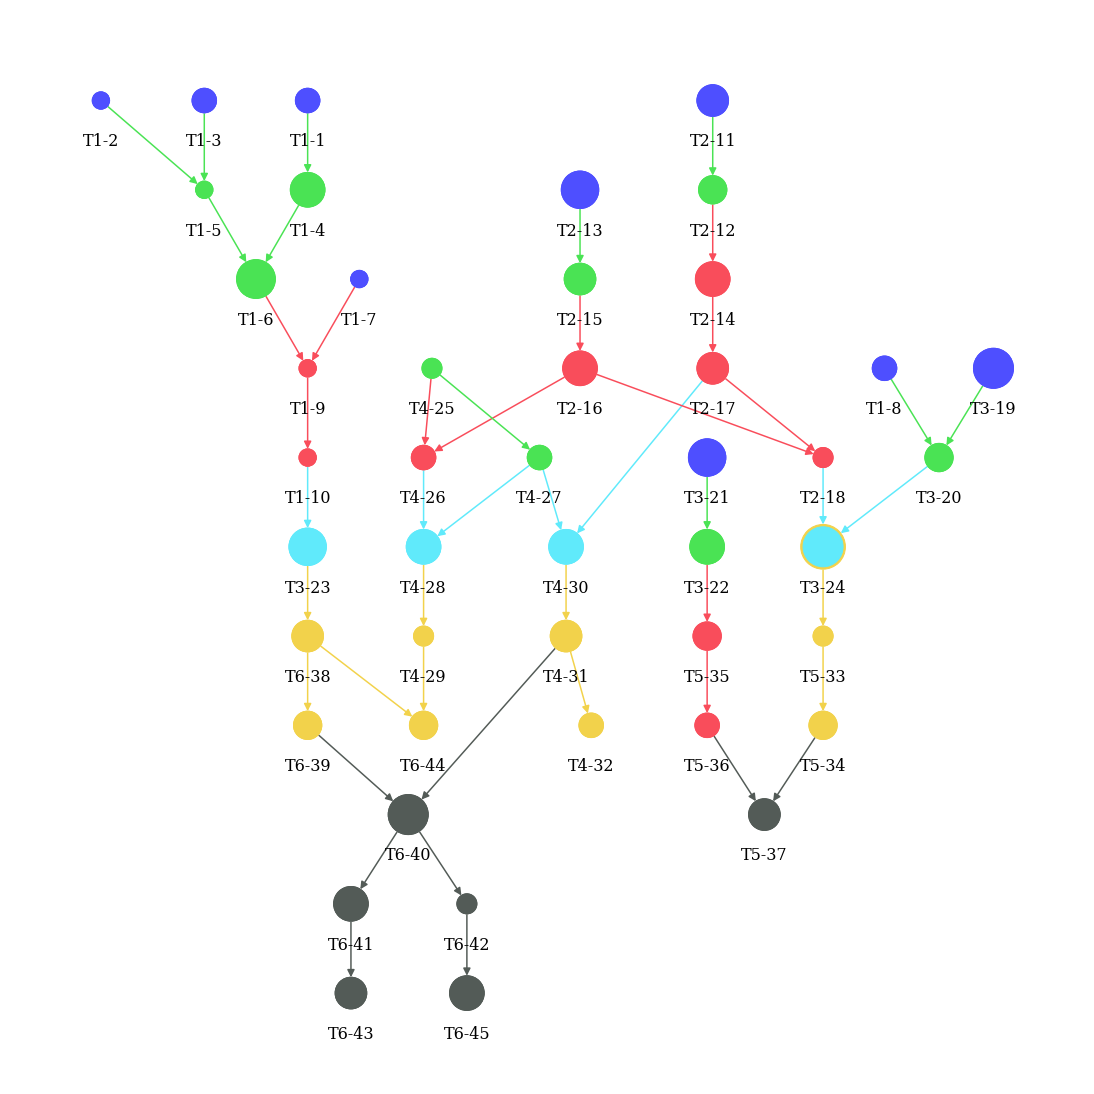

In [14]:
(topic_LPA_sequenced_modules, topic_LPA_sequenced_module_sizes, LPA_sequenced_module_size, LPA_sequenced_module_review_sizes, LPA_sequenced_module_reviewed_topics) = process_modules(LPA_sequenced_modules,LPA_sequenced_module_reviews)

colors = ['#4e4fff', '#4ae354', '#f94d5b', '#60eafb', '#f2d24b', '#535b57']
LPA_sequenced_module_colors = dict(zip(np.arange(0,n_m,1),colors))

LPA_sequenced_module_figure = graph_module_nodes(pos_base,LPA_sequenced_module_colors,topic_LPA_sequenced_modules,topic_LPA_sequenced_module_sizes,"../Curriculum Graphs/Curriculum A-LPA Sequenced Modules.pdf")

## Community Detection

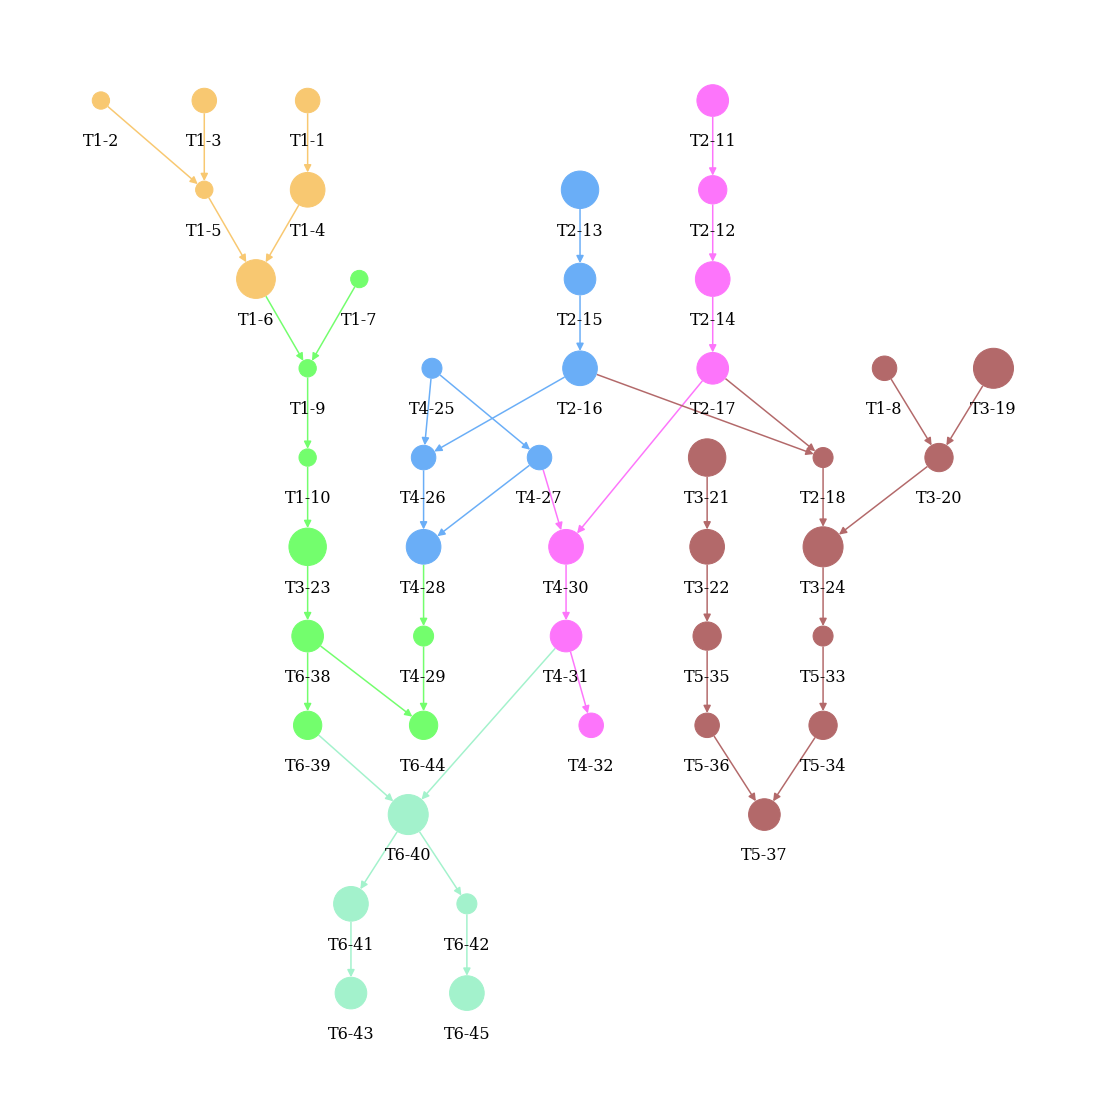

In [15]:
communities = nx.community.greedy_modularity_communities(graph, cutoff = 6, best_n=6)

community_reviews = []
for community in communities:
    for i in community:
        for j in graph.nodes():
            if (i,j) in simple_review_sizes.keys():
                if j not in community:
                    community_reviews.append([i,j])

(topic_communities, topic_communities_sizes, community_size, community_review_sizes, community_reviewed_topics) = process_modules(communities,community_reviews)

n_modules = len(communities)
colors = distinctipy.get_colors(n_modules,pastel_factor=0.7)
for i,color in enumerate(colors):
    colors[i] = mpl.colors.rgb2hex(color)
community_colors = dict(zip(np.arange(0,n_modules,1),colors))

community_figure = graph_module_nodes(pos_base,community_colors,topic_communities,topic_communities_sizes,"../Curriculum Graphs/Curriculum A-Communities.pdf")